In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


In [2]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [5]:
import pickle
prodDES = pd.read_pickle("/Users/yishu/Documents/insight/productDescriptions_raw_and_cleaned.p")

In [19]:
prodDES[:5]

,brand_name,links_image,p_description,p_id,product,p_description_clean
0,Kiehl's Since 1851,https://www.sephora.com/ca/en/productimages/sk...,"<div class=""css-1vwy1pm""><b>Which skin type is...",P421996,Ultra Facial Cream,Which skin type is it good for? Normal Oily C...
1,Kiehl's Since 1851,https://www.sephora.com/ca/en/productimages/sk...,"<div class=""css-1vwy1pm""><b>Which skin type is...",P422013,Calendula Deep Clean Foaming Face Wash,Which skin type is it good for? Normal Oily C...
2,Kiehl's Since 1851,https://www.sephora.com/ca/en/productimages/sk...,"<div class=""css-1vwy1pm""><b>Which skin type is...",P422257,Midnight Recovery Botanical Cleansing Oil,Which skin type is it good for? Normal Oily C...
3,Kiehl's Since 1851,https://www.sephora.com/ca/en/productimages/sk...,"<div class=""css-1vwy1pm""><b>Which skin type is...",P422264,Turmeric & Cranberry Seed Energizing Radiance ...,Which skin type is it good for? Normal Oily C...
4,Kiehl's Since 1851,https://www.sephora.com/ca/en/productimages/sk...,"<div class=""css-1vwy1pm""><b>Which skin type is...",P422016,Hydro-Plumping Re-Texturizing Serum Concentrate,Which skin type is it good for? Normal Oily C...


In [25]:
prodtext = prodDES[["p_description_clean"]]
prodtext[:5]

,p_description_clean
0,Which skin type is it good for? Normal Oily C...
1,Which skin type is it good for? Normal Oily C...
2,Which skin type is it good for? Normal Oily C...
3,Which skin type is it good for? Normal Oily C...
4,Which skin type is it good for? Normal Oily C...


In [36]:
prodtext = prodDES.p_description_clean.values.tolist()
prodtext[0]

'Which skin type is it good for?  Normal Oily Combination Dry Sensitive What it is:  A 24-hour daily face moisturizer. Solutions for: - Dryness  If you want to know more…  Ultra Facial Cream helps reduce moisture loss while drawing and absorbing moisture from the air. With continuous moisture replenishment throughout the day, the luxurious formula leaves skin smooth, soft, and healthy-looking   What else you need to know: Through Ultra Facial Cream, Kiehl’s was honored to lend support and protection from the elements to the heroic team of the “Greenland First Ascent” expedition. The six explorers completed the first-ever ascent of Greenland’s ice covered peaks on May 30th, 2005.  Kiehl’s is inspired by its rich heritage as an old-world apothecary, applying over 165 years’ worth of cosmetic, pharmaceutical, herbal, and medicinal knowledge into the formulations. They utilize the finest natural ingredients and incorporate advanced scientific technologies to ensure the highest quality and 

In [73]:
# Remove Emails
#prodtext = [re.sub('\S*@\S*\s?', '', sent) for sent in prodtext]

# Remove new line characters
prodtext = [re.sub('\s+', ' ', str(sent)) for sent in prodtext]

# Remove distracting single quotes
prodtext = [re.sub("\'", "", str(sent)) for sent in prodtext]

pprint(prodtext[:4])

['Which skin type is it good for? Normal Oily Combination Dry Sensitive What '
 'it is: A 24-hour daily face moisturizer. Solutions for: - Dryness If you '
 'want to know more… Ultra Facial Cream helps reduce moisture loss while '
 'drawing and absorbing moisture from the air. With continuous moisture '
 'replenishment throughout the day, the luxurious formula leaves skin smooth, '
 'soft, and healthy-looking What else you need to know: Through Ultra Facial '
 'Cream, Kiehl’s was honored to lend support and protection from the elements '
 'to the heroic team of the “Greenland First Ascent” expedition. The six '
 'explorers completed the first-ever ascent of Greenland’s ice covered peaks '
 'on May 30th, 2005. Kiehl’s is inspired by its rich heritage as an old-world '
 'apothecary, applying over 165 years’ worth of cosmetic, pharmaceutical, '
 'herbal, and medicinal knowledge into the formulations. They utilize the '
 'finest natural ingredients and incorporate advanced scientific techn

In [37]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

prodtext_words = list(sent_to_words(prodtext))
print(prodtext_words[:1])

In [39]:
# Build the bigram and trigram models
#bigram = gensim.models.Phrasesr(prodDES_words, min_count=5, threshold=100) # higher threshold fewer phrases.
#trigram = gensim.models.Phrases(bigram[prodDES_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[prodtext_words[0]]])

['which', 'skin', 'type', 'is', 'it', 'good', 'for', 'normal', 'oily', 'combination', 'dry', 'sensitive', 'what', 'it', 'is', 'hour', 'daily', 'face', 'moisturizer', 'solutions', 'for', 'dryness', 'if', 'you', 'want', 'to', 'know', 'more', 'ultra', 'facial', 'cream', 'helps', 'reduce', 'moisture', 'loss', 'while', 'drawing', 'and', 'absorbing', 'moisture', 'from', 'the', 'air', 'with', 'continuous', 'moisture', 'replenishment', 'throughout', 'the', 'day', 'the', 'luxurious', 'formula', 'leaves', 'skin', 'smooth', 'soft', 'and', 'healthy', 'looking', 'what', 'else', 'you', 'need', 'to', 'know', 'through', 'ultra', 'facial', 'cream', 'kiehl', 'was', 'honored', 'to', 'lend', 'support', 'and', 'protection', 'from', 'the', 'elements', 'to', 'the', 'heroic', 'team', 'of', 'the', 'greenland', 'first', 'ascent', 'expedition', 'the', 'six', 'explorers', 'completed', 'the', 'first', 'ever', 'ascent', 'of', 'greenland', 'ice', 'covered', 'peaks', 'on', 'may', 'th', 'kiehl', 'is', 'inspired', 'by'

In [40]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [42]:
# Remove Stop Words
prodtext_words_nostops = remove_stopwords(prodtext_words)

# Form Bigrams
prodtext_words_bigrams = make_bigrams(prodtext_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
prodtext_lemmatized = lemmatization(prodtext_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(prodtext_lemmatized[:1])

[['skin', 'type', 'good', 'normal', 'oily', 'combination', 'dry', 'sensitive', 'hour', 'daily', 'face', 'moisturizer', 'solution', 'dryness', 'want', 'know', 'ultra', 'facial', 'cream', 'help', 'reduce', 'moisture', 'loss', 'draw', 'absorb', 'moisture', 'air', 'continuous', 'moisture', 'replenishment', 'day', 'luxurious', 'formula', 'leave', 'skin', 'smooth', 'soft', 'healthy', 'look', 'else', 'need', 'know', 'ultra', 'facial', 'cream', 'kiehl', 'honor', 'lend', 'support', 'protection', 'element', 'heroic', 'team', 'greenland', 'first', 'ascent', 'expedition', 'explorer', 'complete', 'first', 'ever', 'ascent', 'greenland', 'ice', 'cover', 'peak', 'may', 'th', 'kiehl', 'inspire', 'rich', 'heritage', 'old', 'world', 'apply', 'year', 'worth', 'cosmetic', 'pharmaceutical', 'herbal', 'medicinal', 'knowledge', 'formulation', 'utilize', 'fine', 'natural', 'ingredient', 'incorporate', 'advanced', 'scientific', 'technology', 'ensure', 'high', 'quality', 'efficacious', 'formula', 'compromise', '

In [43]:
# Create Dictionary
id2word = corpora.Dictionary(prodtext_lemmatized)

# Create Corpus
texts = prodtext_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 2), (31, 2), (32, 1), (33, 1), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 3), (48, 2), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 3), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 2), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 2), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 2), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1)]]


In [44]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('absorb', 1),
  ('advanced', 1),
  ('air', 1),
  ('apply', 1),
  ('ascent', 2),
  ('biodegradable', 1),
  ('combination', 1),
  ('complete', 1),
  ('compromise', 1),
  ('continuous', 1),
  ('cosmetic', 1),
  ('cover', 1),
  ('cream', 2),
  ('daily', 1),
  ('day', 1),
  ('draw', 1),
  ('dry', 1),
  ('dryness', 1),
  ('efficacious', 1),
  ('efficacy', 1),
  ('element', 1),
  ('else', 1),
  ('ensure', 1),
  ('environment', 1),
  ('ever', 1),
  ('expedition', 1),
  ('explorer', 1),
  ('face', 1),
  ('facial', 2),
  ('fine', 1),
  ('first', 2),
  ('formula', 2),
  ('formulation', 1),
  ('good', 1),
  ('greenland', 2),
  ('healthy', 1),
  ('help', 1),
  ('herbal', 1),
  ('heritage', 1),
  ('heroic', 1),
  ('high', 1),
  ('honor', 1),
  ('hour', 1),
  ('ice', 1),
  ('incorporate', 1),
  ('ingredient', 2),
  ('inspire', 1),
  ('kiehl', 3),
  ('know', 2),
  ('knowledge', 1),
  ('leave', 1),
  ('lend', 1),
  ('look', 1),
  ('loss', 1),
  ('luxurious', 1),
  ('maximize', 1),
  ('may', 1),
  ('

In [74]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=9, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [75]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.056*"note" + 0.032*"white" + 0.023*"mask" + 0.020*"rise" + 0.019*"coffee" '
  '+ 0.017*"floral" + 0.017*"opium" + 0.016*"flower" + 0.015*"fragrance" + '
  '0.012*"fresh"'),
 (1,
  '0.095*"skin" + 0.018*"know" + 0.015*"dry" + 0.015*"type" + 0.014*"oil" + '
  '0.014*"formulate" + 0.012*"product" + 0.011*"test" + 0.011*"texture" + '
  '0.011*"mask"'),
 (2,
  '0.097*"brush" + 0.031*"eye" + 0.026*"fiber" + 0.021*"shade" + '
  '0.020*"palette" + 0.019*"makeup" + 0.019*"shape" + 0.018*"tip" + '
  '0.016*"create" + 0.015*"application"'),
 (3,
  '0.036*"clean" + 0.035*"oil" + 0.027*"edition" + 0.023*"award" + '
  '0.021*"product" + 0.021*"good" + 0.021*"hair" + 0.018*"limited" + '
  '0.016*"winner" + 0.014*"sodium"'),
 (4,
  '0.036*"lash" + 0.026*"set" + 0.013*"mascara" + 0.012*"applicator" + '
  '0.012*"volume" + 0.011*"innovative" + 0.010*"create" + 0.010*"fragrance" + '
  '0.010*"signature" + 0.010*"contain"'),
 (5,
  '0.032*"eye" + 0.026*"skin" + 0.024*"look" + 0.022*"line" + 0.02

In [76]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=prodtext_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.974447020978131

Coherence Score:  0.3913005827853709


In [77]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Applications/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.223121 -0.102835       1        1  29.737913
6      0.180550  0.005109       2        1  16.089407
5      0.144592 -0.041279       3        1  10.203734
4     -0.206762  0.223627       4        1   9.971954
8      0.156161  0.031524       5        1   9.911089
2      0.010470  0.296510       6        1   9.507271
7     -0.222062 -0.176508       7        1   4.987483
3     -0.053914 -0.156069       8        1   4.904127
0     -0.232156 -0.080079       9        1   4.687014, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
79    Default  5291.000000           skin  5291.000000  30.0000  30.0000
1590  Default  1548.000000          brush  1548.000000  29.0000  29.0000
285   Default  1139.000000            lip  1139.000000  28.0000  28.0000
127   Default  1172.000000            oil  1172.000000  27.0000  27.0000
160   Default  1049.000000            eye  1049.000000  26.0000  26.0000
548   Default  1107.000000          color  1107.000000  25.0000  25.0000
1546  Default   593.000000           lash   593.000000  24.0000  24.0000
721   Default   437.000000           note   437.000000  23.0000  23.0000
198   Default   702.000000           mask   702.000000  22.0000  22.0000
67    Default  1499.000000        product  1499.000000  21.0000  21.0000
1579  Default   463.000000     foundation   463.000000  20.0000  20.0000
33    Default   679.000000           good   679.000000  19.0000  19.0000
417   Default   448.000000          clean   448.000000  18.0000  18.0000
91    Default  1061.000000            use  1061.000000  17.0000  17.0000
531   Default   496.000000         powder   496.000000  16.0000  16.0000
1379  Default   435.000000            set   435.000000  15.0000  15.0000
60    Default   787.000000        natural   787.000000  14.0000  14.0000
166   Default  1072.000000         makeup  1072.000000  13.0000  13.0000
359   Default   501.000000           hair   501.000000  12.0000  12.0000
2236  Default   407.000000          fiber   407.000000  11.0000  11.0000
735   Default   576.000000        perfect   576.000000  10.0000  10.0000
3     Default   476.000000          apply   476.000000   9.0000   9.0000
31    Default  1165.000000        formula  1165.000000   8.0000   8.0000
2077  Default   298.000000         animal   298.000000   7.0000   7.0000
27    Default   588.000000           face   588.000000   6.0000   6.0000
1432  Default   571.000000          shade   571.000000   5.0000   5.0000
459   Default   463.000000          matte   463.000000   4.0000   4.0000
225   Default   571.000000           line   571.000000   3.0000   3.0000
454   Default   596.000000         finish   596.000000   2.0000   2.0000
850   Default   335.000000         design   335.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
5493   Topic9    72.328445       discount    73.318634   3.0468  -4.6847
5490   Topic9    69.013329         basket    70.003403   3.0461  -4.7316
1519   Topic9    65.639404           musk    66.629219   3.0454  -4.7818
868    Topic9    63.682091         citrus    64.672241   3.0449  -4.8120
5529   Topic9    62.262165         museum    63.252239   3.0446  -4.8346
1205   Topic9    57.112850          green    58.103046   3.0432  -4.9209
931    Topic9    56.095963  international    57.086494   3.0429  -4.9389
3893   Topic9    52.984863       internal    53.974846   3.0419  -4.9959
6091   Topic9    53.077801      addiction    54.069946   3.0419  -4.9942
4567   Topic9    52.382225         strict    53.372330   3.0416  -5.0074
2847   Topic9    51.726723       restrict    52.716930   3.0414  -5.0200
3326   Topic9    51.659531       european    52.649792   3.0414  -5.0213
3308   Topic9    51.659531    requirement    52.649792   3.0414  -5.0213
2639 

In [51]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/Users/yishu/Downloads/mallet-2.0.8/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [53]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=prodtext_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(5,
  [('mask', 0.061899679829242264),
   ('product', 0.04624688722874422),
   ('face', 0.03468516542155817),
   ('ingredient', 0.029171113482746355),
   ('offer', 0.02703664176449662),
   ('skin', 0.02650302383493419),
   ('formulate', 0.025080042689434364),
   ('test', 0.019743863393810034),
   ('add', 0.0192102454642476),
   ('apply', 0.018854500177872643)]),
 (15,
  [('note', 0.032074375363160955),
   ('fragrance', 0.029866356769320163),
   ('dior', 0.018245206275421266),
   ('floral', 0.0168506682161534),
   ('scent', 0.016153399186519465),
   ('rise', 0.01441022661243463),
   ('white', 0.013712957582800698),
   ('style', 0.012550842533410808),
   ('bergamot', 0.011737361998837886),
   ('flower', 0.011272515979081929)]),
 (6,
  [('skin', 0.2038749449581682),
   ('texture', 0.04953764861294584),
   ('tone', 0.047335975341259356),
   ('uneven', 0.03555702333773668),
   ('radiant', 0.03445618670189344),
   ('dullness', 0.0301629238221048),
   ('good', 0.029172170849845882),
   ('com

In [54]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -6.99870386854487


In [55]:
def compute_coherence_and_perplexity_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [59]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=prodtext_lemmatized, start=2, limit=10, step=1)

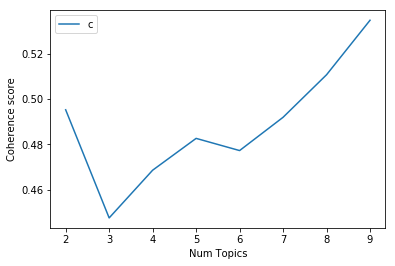

In [60]:
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [67]:
# Select the model and print the topics
optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.036*"color" + 0.034*"finish" + 0.031*"shade" + 0.023*"light" + '
  '0.022*"matte" + 0.017*"powder" + 0.016*"palette" + 0.015*"set" + '
  '0.013*"feature" + 0.013*"create"'),
 (1,
  '0.059*"skin" + 0.028*"eye" + 0.023*"line" + 0.022*"wrinkle" + '
  '0.021*"appearance" + 0.019*"formulate" + 0.018*"reduce" + 0.018*"dark" + '
  '0.018*"cream" + 0.017*"visibly"'),
 (2,
  '0.038*"product" + 0.036*"ingredient" + 0.030*"formula" + 0.029*"natural" + '
  '0.022*"hair" + 0.020*"oil" + 0.020*"fine" + 0.019*"good" + 0.019*"type" + '
  '0.019*"skin"'),
 (3,
  '0.087*"brush" + 0.040*"makeup" + 0.036*"application" + 0.025*"fiber" + '
  '0.024*"foundation" + 0.019*"perfect" + 0.019*"shape" + 0.019*"make" + '
  '0.018*"product" + 0.018*"apply"'),
 (4,
  '0.067*"lip" + 0.039*"soft" + 0.024*"moisture" + 0.022*"formula" + '
  '0.022*"hour" + 0.020*"provide" + 0.020*"moisturize" + 0.020*"lightweight" + '
  '0.019*"nourish" + 0.018*"hydrate"'),
 (5,
  '0.038*"lash" + 0.032*"eye" + 0.031*"formula" +

In [69]:
conv_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

In [71]:
pprint(conv_model.print_topics(num_words=10))

[(0,
  '0.000*"tricky" + 0.000*"skinny" + 0.000*"inducing" + 0.000*"exude" + '
  '0.000*"department" + 0.000*"daily" + 0.000*"phthalate" + 0.000*"infuse" + '
  '0.000*"meet" + 0.000*"actual"'),
 (1,
  '0.000*"mexico" + 0.000*"triangular" + 0.000*"mallow" + 0.000*"definer" + '
  '0.000*"invisible" + 0.000*"sunscreen" + 0.000*"nuit" + 0.000*"richly" + '
  '0.000*"biscuit" + 0.000*"artisanship"'),
 (2,
  '0.000*"month" + 0.000*"frankincense" + 0.000*"alleviate" + 0.000*"trap" + '
  '0.000*"toe" + 0.000*"dogwood" + 0.000*"beginner" + 0.000*"reliably" + '
  '0.000*"semi" + 0.000*"outlast"'),
 (3,
  '0.000*"subtly" + 0.000*"glove" + 0.000*"imbue" + 0.000*"ferment" + '
  '0.000*"minimized" + 0.000*"react" + 0.000*"possibility" + 0.000*"super" + '
  '0.000*"spray" + 0.000*"model"'),
 (4,
  '0.000*"hound" + 0.000*"glitter" + 0.000*"white" + 0.000*"demachy" + '
  '0.000*"commit" + 0.000*"rehydrate" + 0.000*"pepper" + 0.000*"pouch" + '
  '0.000*"brightening" + 0.000*"recovery"'),
 (5,
  '0.000*"s

In [70]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(conv_model, corpus, id2word)
vis

/Applications/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x             y  topics  cluster       Freq
topic                                                    
7      0.000023  1.382651e-04       1        1  14.178303
1      0.000247 -2.505218e-04       2        1  12.517636
8      0.000143  9.527303e-05       3        1  11.025365
0      0.000960 -5.169513e-07       4        1  10.976740
3      0.000397 -2.862802e-04       5        1  10.865923
4     -0.000514 -3.068682e-04       6        1  10.412535
6     -0.000454 -8.469774e-04       7        1  10.220484
2     -0.000809  4.834445e-04       8        1  10.004788
5      0.000008  9.741820e-04       9        1   9.798227, topic_info=     Category       Freq           Term      Total  loglift  logprob
term                                                                
865   Default  27.000000   frankincense  27.000000  30.0000  30.0000
4484  Default  26.000000       saucepan  26.000000  29.0000  29.0000
2200  Default  25.000000           cube  25.000000  28.0000  28.0000
5187  Default  25.000000     cumulative  25.000000  27.0000  27.0000
1388  Default  27.000000      refreshed  27.000000  26.0000  26.0000
5307  Default  26.000000         commit  26.000000  25.0000  25.0000
18    Default  26.000000    efficacious  26.000000  24.0000  24.0000
4927  Default  25.000000          scope  25.000000  23.0000  23.0000
3008  Default  26.000000            toe  26.000000  22.0000  22.0000
5569  Default  25.000000           duos  25.000000  21.0000  21.0000
1743  Default  26.000000       mandarin  26.000000  20.0000  20.0000
5847  Default  26.000000      francisco  26.000000  19.0000  19.0000
3700  Default  25.000000         muscat  25.000000  18.0000  18.0000
5891  Default  26.000000        dogwood  26.000000  17.0000  17.0000
5431  Default  26.000000          vault  26.000000  16.0000  16.0000
3590  Default  28.000000          arrow  28.000000  15.0000  15.0000
2083  Default  25.000000     invitation  25.000000  14.0000  14.0000
2674  Default  26.000000           fuss  26.000000  13.0000  13.0000
6047  Default  26.000000       holidaze  26.000000  12.0000  12.0000
3673  Default  25.000000   illumination  25.000000  11.0000  11.0000
4545  Default  26.000000       inducing  26.000000  10.0000  10.0000
4338  Default  26.000000         muguet  26.000000   9.0000   9.0000
1601  Default  26.000000         ablaze  26.000000   8.0000   8.0000
202   Default  25.000000        restore  25.000000   7.0000   7.0000
1401  Default  25.000000        moringa  25.000000   6.0000   6.0000
2676  Default  26.000000      raspberry  26.000000   5.0000   5.0000
4853  Default  26.000000       cordycep  26.000000   4.0000   4.0000
1035  Default  26.000000          month  26.000000   3.0000   3.0000
1949  Default  26.000000         island  26.000000   2.0000   2.0000
5051  Default  26.000000           hall  26.000000   1.0000   1.0000
...       ...        ...            ...        ...      ...      ...
6017   Topic9   3.325144        hickory  26.696571   0.2399  -8.5018
6253   Topic9   3.347762       plumetis  27.002940   0.2353  -8.4951
1790   Topic9   3.143209         lively  25.397556   0.2336  -8.5581
1692   Topic9   3.224352           curl  26.105799   0.2315  -8.5326
972    Topic9   3.177778         clarin  25.787891   0.2292  -8.5472
1776   Topic9   3.298728           cois  26.774335   0.2291  -8.5098
4205   Topic9   3.247434           curb  26.398891   0.2275  -8.5255
279    Topic9   3.255008     buttermask  26.484080   0.2266  -8.5232
3773   Topic9   3.377948   buildability  27.531324   0.2249  -8.4861
3961   Topic9   3.199139       multiuse  26.158401   0.2217  -8.5405
1298   Topic9   3.445895           gmos  28.179695   0.2216  -8.4662
4633   Topic9   3.344157      aquaporin  27.405646   0.2194  -8.4961
6079   Topic9   3.345569      covetable  27.427563   0.2191  -8.4957
1534   Topic9   3.249458      customize  26.644210   0.2189  -8.5249
3049   Topic9   3.368070         regard  27.626395   0.2185  -8.4890
6124   